In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import pystan

import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.2)

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline

from IPython.display import display

In [2]:
# create a database connection
sqluser = 'mimic'
dbname = 'mimic'
schema_name = 'mimiciii'

cur = None

In [3]:
if cur: 
    cur.close()
    con.close()

con = psycopg2.connect(dbname = dbname, user = sqluser, host='/var/run/postgresql')
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [4]:
query = """
SELECT * FROM icu_features
"""
ef = pd.read_sql_query(query, con)
ef.head()

,icustay_id,hadm_id,subject_id,age,gender,height,weight,bmi,ethnicity,insurance,...,ea_tv_pulm_htn,ea_tv_tr,ea_lv_cavity,ea_lv_diastolic,ea_lv_systolic,ea_lv_wall,ea_rv_cavity,ea_rv_diastolic_fluid,ea_rv_systolic,ea_rv_wall
0,238355,134607,82139,28678 days 18:29:29,M,180.34,38.555351,11.854972,UNKNOWN/NOT SPECIFIED,Medicare,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,274568,151968,65810,16135 days 23:13:48,M,187.96,44.588130,12.620844,WHITE,Medicaid,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN
2,246663,128345,28902,23528 days 12:26:14,M,182.88,80.699997,24.129098,WHITE,Private,...,2.0,1.0,2.0,1.0,3.0,1.0,0.0,NaN,0.0,NaN
3,270608,118555,4734,22639 days 20:28:13,F,NaN,74.000000,NaN,WHITE,Private,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,260990,111727,27334,30774 days 01:32:22,M,167.64,61.800000,21.990402,WHITE,Private,...,NaN,0.0,0.0,1.0,0.0,3.0,0.0,NaN,0.0,NaN


In [5]:
len(ef)

61532

In [6]:
ef.ea_lv_systolic.fillna(-2, inplace=True)

In [7]:
## apply filters
F = (ef['filter_vaso'] | ef['filter_angus_sepsis']) \
        & ef['filter_micu'] \
        & ~ef['filter_hard_cardiogenic'] \
        & ~ef['filter_chronic_dialysis'] \
        & ef['filter_adult']

In [8]:
ef = ef.loc[F]
len(ef)

9681

In [9]:
day30_mortality = (ef.dod - ef.intime) < np.timedelta64(30, 'D')

In [10]:
day30_mortality.value_counts()

False    6911
True     2770
dtype: int64

In [11]:
ef['day30_mortality'] = day30_mortality

In [16]:
def mdrd(data):
    creat = data.lab_creatinine
    age = data.age/np.timedelta64('1', 'Y')
    age.loc[age<0] = age.max()
    gender = data.gender.apply(lambda x: 0.742 if x == 'F' else 1)
    ethnicity = data.ethnicity.apply(lambda x: 1.212 if 'AFRICAN AMERICAN' in x else 1)
    return 175*creat**(-1.154) * age**(-0.203) * gender * ethnicity

In [17]:
value = mdrd(ef)
ef['mdrd'] = value
discrete = pd.cut(value, [0, 15, 30, 44, 60, 90, 1000000], labels=[5, 4, 3, 2, 1, 0], include_lowest=True)
ef['mdrd_discrete'] = discrete
discrete.value_counts()

0    2351
1    2038
2    1588
4    1534
3    1515
5     581
dtype: int64

In [18]:
discrete = pd.cut(value, [0, 30, 60, 1000000], labels=[2, 1, 0], include_lowest=True)
ef['mdrd_3'] = discrete
discrete.value_counts()

0    4389
1    3103
2    2115
dtype: int64

In [37]:
model_data = ef[['ea_lv_systolic', 'ex_congestive_heart_failure'
                #, 'mech_vent'
                , 'mdrd', 'mdrd_discrete', 'mdrd_3', 'apsiii'
                , 'fb_day1_balance_ml', 'day30_mortality']].copy()
age = ef.age/np.timedelta64('1', 'Y')
age.loc[age<0] = age.max()
model_data['age'] = age
model_data.loc[model_data.ea_lv_systolic == -50] = np.nan
model_data = model_data.dropna()
## normalize the continuous variables
for var in ['apsiii', 'age', 'fb_day1_balance_ml', 'mdrd']:
    mu = model_data[var].mean()
    std = model_data[var].std()
    model_data[var] = (model_data[var]-mu)/std
model_data['ea_lv_systolic'] = model_data.ea_lv_systolic.astype(int) + 3
model_data['ex_congestive_heart_failure'] = model_data.ex_congestive_heart_failure.astype(int)
#model_data['mech_vent'] = model_data.mech_vent.astype(int)
model_data['day30_mortality'] = model_data.day30_mortality.astype(int)
model_data['mdrd_discrete'] = model_data.mdrd_discrete.astype(int) + 1
model_data['mdrd_3'] = model_data.mdrd_3.astype(int) + 1
print(len(model_data))
model_data.head()

6880


,ea_lv_systolic,ex_congestive_heart_failure,mdrd,mdrd_discrete,mdrd_3,apsiii,fb_day1_balance_ml,day30_mortality,age
14,1,1,-0.157392,2,1,-0.163425,-0.099108,0,0.729909
22,2,0,-0.620357,4,2,0.778665,2.778313,1,1.305196
25,1,0,0.382788,1,1,-1.195237,-1.354572,0,-1.345441
29,1,0,0.881338,1,1,0.778665,-0.354457,1,0.668275
31,3,1,-0.341061,3,2,0.105744,-0.351818,0,-0.750011


### Model using continuous MDRD

In [38]:
data = {'N': len(model_data)
       , 'ea_lv_systolic': model_data.ea_lv_systolic
       , 'ex_congestive_heart_failure': model_data.ex_congestive_heart_failure
       #, 'mech_vent': model_data.mech_vent
       , 'mdrd': model_data.mdrd
       , 'apsiii': model_data.apsiii
       , 'age': model_data.age
       , 'fluid_day1_balance': model_data.fb_day1_balance_ml
       , 'y': model_data.day30_mortality
       }

In [42]:
%%writefile 170207_model_linear_MICU_pressors_and_sepsis_TB.stan

data{
    int<lower=0> N;
    
    int<lower=1, upper=6> ea_lv_systolic[N];
    vector[N] ex_congestive_heart_failure;
    //vector[N] mech_vent;
    vector[N] mdrd;
    vector[N] apsiii;
    vector[N] age;
    vector[N] fluid_day1_balance;
    
    int<lower=0, upper=1> y[N];
}

parameters{
    real bias;
    
    vector[6] beta_ea_lv_systolic;
    real beta_ex_congestive_heart_failure;
    //real beta_mech_vent;
    real beta_mdrd;
    real beta_apsiii;
    real beta_age;
    real beta_fluid;
    
    vector[6] gamma_ea_lv_systolic;
    real gamma_ex_congestive_heart_failure;
    //real gamma_mech_vent;
    real gamma_mdrd;
    
    vector[6] gamma_lv_sys_by_chf;
    vector[6] gamma_lv_sys_by_mdrd;
    
}

transformed parameters {
    vector[N] y_hat;
    vector[N] beta;
    vector[N] gamma;
    
    beta = bias + beta_ea_lv_systolic[ea_lv_systolic]
        + beta_ex_congestive_heart_failure*ex_congestive_heart_failure
        //+ beta_mech_vent*mech_vent
        + beta_mdrd*mdrd
        + beta_apsiii*apsiii
        + beta_age*age;
    
    gamma = beta_fluid + gamma_ea_lv_systolic[ea_lv_systolic]
        + gamma_ex_congestive_heart_failure*ex_congestive_heart_failure
        //+ gamma_mech_vent*mech_vent
        + gamma_mdrd*mdrd
        + gamma_lv_sys_by_chf[ea_lv_systolic] .* ex_congestive_heart_failure
        + gamma_lv_sys_by_mdrd[ea_lv_systolic] .* mdrd;
    
    y_hat = beta + gamma .* fluid_day1_balance;
}

model {
    beta_ea_lv_systolic ~ normal(0,1);
    beta_ex_congestive_heart_failure ~ normal(0,1);
    //beta_mech_vent ~ normal(0,1);
    beta_mdrd ~ normal(0,1);
    beta_apsiii ~ normal(0,1);
    beta_age ~ normal(0,1);
    
    beta_fluid ~ normal(0,1);
    gamma_ea_lv_systolic ~ normal(0,1);
    gamma_ex_congestive_heart_failure ~ normal(0,1);
    //gamma_mech_vent ~ normal(0,1);
    gamma_mdrd ~ normal(0,1);
    gamma_lv_sys_by_chf ~ normal(0,1);
    gamma_lv_sys_by_mdrd ~ normal(0,1);
    
    y ~ bernoulli_logit(y_hat);
}


Overwriting 170207_model_linear_MICU_pressors_and_sepsis_TB.stan


In [39]:
def gamma(thetas, xs):
    gamma = thetas['beta_fluid'] + thetas['gamma_ea_lv_systolic'][:,xs.ea_lv_systolic-1].T
    gamma += np.outer(xs.ex_congestive_heart_failure, thetas['gamma_ex_congestive_heart_failure'])
    #gamma += np.outer(xs.mech_vent, thetas['gamma_mech_vent'])
    gamma += np.outer(xs.mdrd, thetas['gamma_mdrd'])
    gamma += thetas['gamma_lv_sys_by_chf'][:,xs.ea_lv_systolic-1].T * xs.ex_congestive_heart_failure.values[...,np.newaxis]
    gamma += thetas['gamma_lv_sys_by_mdrd'][:,xs.ea_lv_systolic-1].T * xs.mdrd.values[...,np.newaxis]
    return gamma
    

In [40]:
def predict_linear(thetas, xs):
    beta = thetas['bias'] + thetas['beta_ea_lv_systolic'][:,xs.ea_lv_systolic-1].T
    beta += np.outer(xs.ex_congestive_heart_failure, thetas['beta_ex_congestive_heart_failure'])
    #beta += np.outer(xs.mech_vent, thetas['beta_mech_vent'])
    beta += np.outer(xs.mdrd, thetas['beta_mdrd'])
    beta += np.outer(xs.apsiii, thetas['beta_apsiii'])
    beta += np.outer(xs.age, thetas['beta_age'])
    
    return beta + gamma(thetas, xs)*xs.fb_day1_balance_ml.values[...,np.newaxis]


In [43]:
#compile the model
model_linear = pystan.StanModel(file='170207_model_linear_MICU_pressors_and_sepsis_TB.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cd12d70eb2408c04203fa8ddc2e6c6f1 NOW.


In [44]:
#fit the model
model_fit = model_linear.sampling(data, chains=1, iter=4000, algorithm='NUTS')

In [45]:
model_fit

Exception KeyboardInterrupt in 'pystan._chains.get_chain_mean' ignored
Exception KeyboardInterrupt in 'pystan._chains.get_chain_mean' ignored
Exception KeyboardInterrupt in 'pystan._chains.get_chain_mean' ignored


KeyboardInterrupt: 

### Take a look at model accuracy

In [46]:
y_hats = model_fit.extract('y_hat')
y_hats = pd.DataFrame(y_hats['y_hat'])
y_hats.head()

,0,1,2,3,4,5,6,7,8,9,...,6870,6871,6872,6873,6874,6875,6876,6877,6878,6879
0,-0.923314,0.777870,-2.429201,0.010076,-1.246212,-1.820478,-1.245418,-0.932242,-1.975703,-0.892929,...,-1.837554,-0.774009,-2.978596,-1.454011,-0.858555,-1.078430,-2.915516,0.502840,-2.234352,-0.717123
1,-0.959228,1.667679,-2.736150,-0.077935,-1.209348,-1.824890,-1.401062,-1.019736,-1.961254,-0.904450,...,-1.847940,-0.817276,-3.189388,-1.477799,-0.796858,-1.157918,-3.136614,0.493672,-2.394632,-0.720533
2,-1.046017,1.215044,-2.525115,0.122071,-1.299359,-1.766916,-1.204936,-0.907703,-1.936878,-1.036554,...,-1.967036,-0.741420,-3.083109,-1.600156,-1.176521,-1.069487,-2.979029,0.675247,-2.097363,-0.722532
3,-1.109985,1.114817,-2.625776,0.101358,-1.566531,-1.919562,-1.221876,-0.966428,-2.116730,-1.092987,...,-2.179350,-0.780043,-3.135125,-1.798248,-1.228577,-1.118747,-3.025503,0.674422,-2.152741,-0.776648
4,-1.054637,1.262189,-2.585865,0.013218,-1.362626,-1.764637,-1.266052,-0.891735,-1.901378,-0.998861,...,-2.010632,-0.720550,-3.018804,-1.616008,-1.098071,-1.025572,-2.912462,0.592149,-2.037045,-0.008307


In [47]:
y_hat_mu = y_hats.mean()

In [48]:
y_hat_p = 1./(1+np.exp(-y_hat_mu))

In [55]:
model_data.day30_mortality.mean()

0.2880813953488372

In [49]:
((y_hat_p >= 0.5) == model_data.day30_mortality).mean()

0.75363372093023251

In [50]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

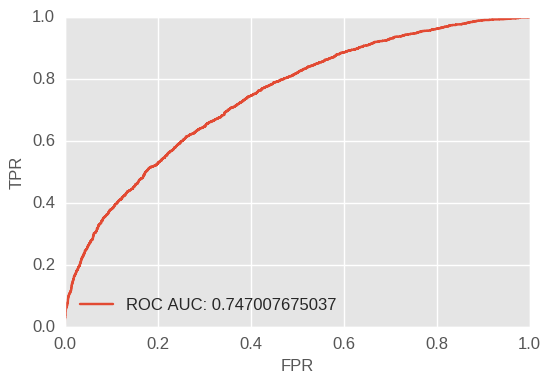

In [51]:
fpr, tpr, _ = roc_curve(model_data.day30_mortality, y_hat_mu)
aucroc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC AUC: {}'.format(aucroc))
plt.legend(loc='best')
plt.xlabel('FPR')
plt.ylabel('TPR')

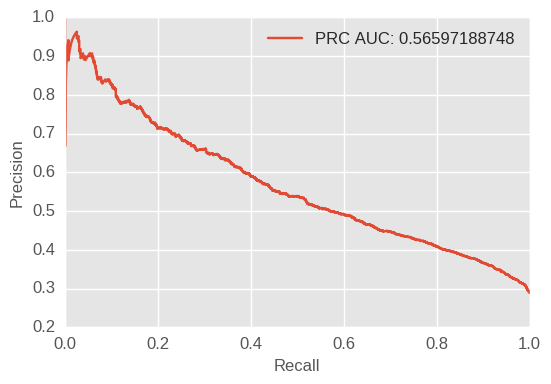

In [52]:
prec, rec, _ = precision_recall_curve(model_data.day30_mortality, y_hat_mu)
aucprc = auc(rec, prec)
plt.plot(rec, prec, label='PRC AUC: {}'.format(aucprc))
plt.legend(loc='best')
plt.xlabel('Recall')
plt.ylabel('Precision')

In [56]:
def threshold_accuracy(y_true, y_pred):
    I = y_pred.argsort()
    y_true = y_true[I]
    y_pred = y_pred[I]
    tru = np.cumsum(y_true[::-1])[::-1]
    fls = np.cumsum(1-y_true) - 1
    cor = tru+fls
    acc = cor / float(len(y_pred))
    return acc, y_pred, y_true

0.754796511628 -0.0277016987267


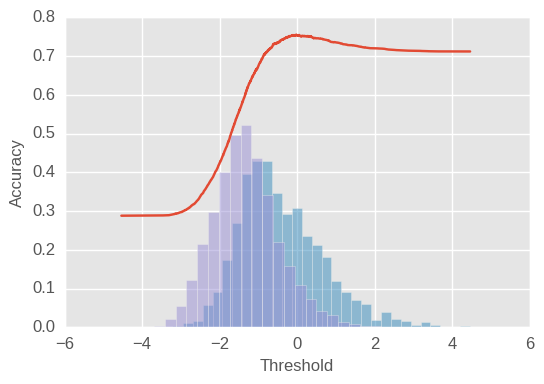

In [57]:
acc, thresh, label = threshold_accuracy(model_data.day30_mortality.values, y_hat_mu.values)
i = np.argmax(acc)
print(acc[i], thresh[i])
plt.plot(thresh, acc)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.hist(thresh[label==1], normed=True, alpha=0.5, bins=30)
plt.hist(thresh[label==0], normed=True, alpha=0.5, bins=30)
pass

In [58]:
model_data.day30_mortality.mean()

0.2880813953488372

### Plot some prediction vs fluid balance curves

In [60]:
thetas_linear = model_fit.extract(['bias', 'beta_ea_lv_systolic', 'beta_ex_congestive_heart_failure'
                                          #, 'beta_mech_vent'
                                          , 'beta_mdrd', 'beta_apsiii', 'beta_age', 'beta_fluid'
                                          , 'gamma_ea_lv_systolic', 'gamma_ex_congestive_heart_failure'
                                          #, 'gamma_mech_vent'
                                          , 'gamma_mdrd', 'gamma_lv_sys_by_chf'
                                          , 'gamma_lv_sys_by_mdrd'])

In [61]:
flags = ['ex_congestive_heart_failure', 'ea_lv_systolic', 'mech_vent', 'mdrd', 'apsiii', 'age']

def predict_quantiles(fluid_range, df, as_logit=True):
    fluid_df = pd.DataFrame({'fb_day1_balance_ml': fluid_range})
    df = df.copy()
    del df['day30_mortality']
    del df['mdrd_discrete']
    del df['mdrd_3']
    
    q = [2.5, 50., 97.5]
    quants = np.zeros((len(fluid_range), 1+len(q)))
    for i,fl in enumerate(fluid_range):
        df['fb_day1_balance_ml'] = fl
        yh = predict_linear(thetas_linear, df)
        if not as_logit:
            yh = 1./(1. + np.exp(-yh))
        quants[i,0] = np.mean(yh)
        quants[i,1:] = np.percentile(yh, q)
    
    return quants

In [ ]:
mi, ma = model_data.fb_day1_balance_ml.min(), model_data.fb_day1_balance_ml.max()
fluid_range = np.linspace(mi, ma, 100)
def df_predict_quantiles(df):
    q = predict_quantiles(fluid_range, df)
    return pd.DataFrame(q)
chf_quantiles = model_data.groupby('ex_congestive_heart_failure').apply(df_predict_quantiles)
chf_quantiles.reset_index(level=0, inplace=True)
chf_quantiles.head()

,ex_congestive_heart_failure,0,1,2,3
0,0,-0.785369,-5.248307,-0.945419,3.977319
1,0,-0.791022,-5.184080,-0.949702,3.907538
2,0,-0.796674,-5.120232,-0.953941,3.837680
3,0,-0.802327,-5.056159,-0.958277,3.768410
4,0,-0.807980,-4.992354,-0.962620,3.700065


In [ ]:
def df_predict_quantiles_p(df):
    q = predict_quantiles(fluid_range, df, as_logit=False)
    return pd.DataFrame(q)
chf_p_quantiles = model_data.groupby('ex_congestive_heart_failure').apply(df_predict_quantiles_p)
chf_p_quantiles.reset_index(level=0, inplace=True)
chf_p_quantiles.head()

In [ ]:
fig, ax = plt.subplots(4, figsize=(6, 16), sharex=True)
color = ['r', 'b']
for flag,df in chf_quantiles.groupby('ex_congestive_heart_failure'):
    quants = df[[0,1,2,3]].values #, as_logit=False)
    mu = quants[:,0]
    lo = quants[:,1]
    med = quants[:,2]
    hi = quants[:,3]
    ax[0].plot(fluid_range, mu, color[flag], label=str(flag) + ' mean')
    ax[0].plot(fluid_range, med, '--'+color[flag], label=str(flag) + ' median')
    ax[0].fill_between(fluid_range, hi, lo, color='gray', alpha=0.5)
    #md_flag = model_data.loc[model_data.ex_congestive_heart_failure == flag]
    #ax[1].hist(md_flag.fb_day1_balance_ml, normed=True, alpha=0.5, bins=20)
    #for f2,mddf in md_flag.groupby('day30_mortality'):
    #    ax[2].hist(mddf.fb_day1_balance_ml, normed=True, bottom=f2, alpha=0.5
    #               , label='CHF: '+str(flag)+', Mortality:'+str(f2))
    #ax[2].plot(md_flag.fb_day1_balance_ml, md_flag.day30_mortality, '.', label=flag)
for flag,df in chf_p_quantiles.groupby('ex_congestive_heart_failure'):
    quants = df[[0,1,2,3]].values #, as_logit=False)
    mu = quants[:,0]
    lo = quants[:,1]
    med = quants[:,2]
    hi = quants[:,3]
    ax[1].plot(fluid_range, mu, color[flag], label=str(flag) + ' mean')
    ax[1].plot(fluid_range, med, '--'+color[flag], label=str(flag) + ' median')
    ax[1].fill_between(fluid_range, hi, lo, color='gray', alpha=0.5)    
ax[0].legend(loc='best')
_ = ax[0].set_xlim((mi, ma))
#_ = ax[0].set_ylim((-6, 20))

to_plot = model_data.copy()
to_plot['day30_mortality'] = -1
to_plot = pd.concat([to_plot, model_data], axis=0)
sns.boxplot(ax=ax[2], data=to_plot, y='ex_congestive_heart_failure', x='fb_day1_balance_ml', hue='day30_mortality'
           , orient='h')
sns.stripplot(ax=ax[3], x='fb_day1_balance_ml', y='ex_congestive_heart_failure', hue='day30_mortality'
              ,data=to_plot, split=True, jitter=True, size=3, linewidth=0, orient='h')
_ = ax[3].legend().set_visible(False)

### Take a look at the posteriors of some of the parameters

In [ ]:
factors = model_fit.extract(['beta_age', 'beta_apsiii', 'beta_ex_congestive_heart_failure'
                             #, 'beta_mech_vent'
                            , 'beta_mdrd'])
plt.figure(figsize=(8, 4))
for key in ['age', 'apsiii', 'ex_congestive_heart_failure'
            #, 'mech_vent'
            , 'mdrd']:
    sns.kdeplot(factors['beta_'+key], label=key)
plt.legend(loc='best')

In [ ]:
beta_lv_sys = model_fit.extract('beta_ea_lv_systolic')['beta_ea_lv_systolic']
for i in range(6):
    sns.kdeplot(beta_lv_sys[:,i], label=str(i-2))
plt.legend(loc='best')

In [ ]:
## calculate the marginal parameter on the fluids term
gamma_marginal = gamma(thetas_linear, model_data)
sns.kdeplot(gamma_marginal.ravel())
gamma_marginal.mean(), gamma_marginal.std(), np.percentile(gamma_marginal, 50)

In [ ]:
sns.kdeplot(model_fit.extract('beta_fluid')['beta_fluid'])

In [ ]:
gamma_lv_sys = model_fit.extract('gamma_ea_lv_systolic')['gamma_ea_lv_systolic']
for i in range(6):
    sns.kdeplot(gamma_lv_sys[:,i], label=str(i-2))
plt.legend(loc='best')

In [ ]:
gamma_lv_sys_by_chf = model_fit.extract('gamma_lv_sys_by_chf')['gamma_lv_sys_by_chf']
for i in range(6):
    sns.kdeplot(gamma_lv_sys_by_chf[:,i], label=str(i-2))
plt.legend(loc='best')

In [ ]:
gamma_lv_sys_by_mdrd = model_fit.extract('gamma_lv_sys_by_mdrd')['gamma_lv_sys_by_mdrd']
for i in range(6):
    sns.kdeplot(gamma_lv_sys_by_mdrd[:,i], label=str(i-2))
plt.legend(loc='best')